In [1]:
import os
os.chdir("../")

In [2]:
from vnstock import *

screener_df = Screener().stock(params={"exchangeName": "HOSE"}, limit=1700)


In [3]:
stock_df = screener_df[["ticker", "market_cap"]]
stock_df = stock_df.dropna()
stock_df = stock_df.sort_values("market_cap", ascending=False)

In [4]:
stocks = stock_df[:120]["ticker"]

In [5]:
from crawler.Tv_loader import TvDatafeed,Interval
import os, time
import pandas as pd

os.environ['TZ'] = 'Asia/Ho_Chi_Minh'
time.tzset()    

def load_data_direct(ticker, exchange = "", interval = "1D"):
    username = 'thanhtrunghuynh93'
    password = '@Manutd93@'
    crawler=TvDatafeed(username, password, chromedriver_path="chromedriver")
    if interval == "1D":
        df = crawler.get_hist(symbol=ticker,exchange=exchange,interval=Interval.in_daily, n_bars = 5000)
    if interval == "1W":
        df = crawler.get_hist(symbol=ticker,exchange=exchange,interval=Interval.in_weekly, n_bars = 5000)
    df["ticker"] = ticker
    return df

In [6]:
dfs = []
for stock in stocks:
    print(stock)
    df = load_data_direct(stock, exchange = "HOSE", interval = "1W")    
    dfs.append(df)


VCB
VIC
VHM
BID
TCB
VPB
CTG
MBB
HPG
FPT
GAS
ACB
LPB
VNM
MSN
GVR
HDB
MWG
STB
HVN
VJC
BSR
SHB
VIB
SSI
VRE
BCM
SSB
SAB
TPB
EIB
VIX
GEX
PLX
MSB
BVH
GEE
KDH
POW
DGC
KBC
OCB
REE
VND
NVL
VCI
PNJ
HCM
NAB
VGC
GMD
PGV
PDR
FRT
DXG
SBT
DCM
SJS
HAG
TCH
DPM
VPI
VCG
NLG
KDC
CII
SIP
DIG
DHG
FTS
VHC
BSI
VTP
TAL
LGC
PVD
BMP
HSG
VSH
VSC
HDG
BAF
BWE
EVF
VAB
DBC
DSE
CTR
PC1
HAH
DGW
VCF
KOS
PVT
CMG
IMP
CTS
BHN
PHR
CTD
TMS
HHV
NKG
ANV
HHS
DXS
PAN
TDM
VDS
HT1
NT2
SZC
SCS
BIC
HDC
HNA
GEG
PDN
DBD
CHP


In [7]:
stock_1w_data = {}
stock_list = []
benchmark_df = dfs[0][-300:]
for df in dfs:
    if len(df) >= 300:
        if df[-300:]["volume"].mean() > 100000:
            insight_df = df[-300:]
            if insight_df.index[0] == benchmark_df.index[0]:
                ticker = df.iloc[0]["ticker"]
                stock_list.append(ticker)
                stock_1w_data[ticker] = insight_df
        
        

In [8]:
print(len(stock_list))

89


In [9]:
print(stock_list)

['VCB', 'VIC', 'VHM', 'BID', 'TCB', 'VPB', 'CTG', 'MBB', 'HPG', 'FPT', 'GAS', 'ACB', 'VNM', 'MSN', 'HDB', 'MWG', 'STB', 'HVN', 'VJC', 'BSR', 'SHB', 'SSI', 'VRE', 'SAB', 'TPB', 'EIB', 'GEX', 'PLX', 'BVH', 'KDH', 'POW', 'KBC', 'REE', 'NVL', 'VCI', 'PNJ', 'HCM', 'VGC', 'GMD', 'PDR', 'FRT', 'DXG', 'SBT', 'DCM', 'SJS', 'HAG', 'TCH', 'DPM', 'VPI', 'NLG', 'KDC', 'CII', 'DIG', 'DHG', 'FTS', 'VHC', 'PVD', 'BMP', 'HSG', 'VSH', 'VSC', 'HDG', 'BWE', 'DBC', 'CTR', 'PC1', 'HAH', 'DGW', 'KOS', 'PVT', 'CMG', 'IMP', 'CTS', 'PHR', 'CTD', 'TMS', 'NKG', 'ANV', 'HHS', 'TDM', 'HT1', 'NT2', 'SZC', 'SCS', 'BIC', 'HDC', 'GEG', 'DBD', 'CHP']


In [10]:
price_data = {}
vol_data = {}

for stock in stock_list:
    price_data[stock] = stock_1w_data[stock]["close"]    
    vol_data[stock] = stock_1w_data[stock]["volume"]    
    
df = pd.DataFrame(price_data)
df.index = pd.to_datetime(df.index)
df_pc = df.pct_change()
df_pc = df_pc[1:]
df_price = df.copy()
df_vol = pd.DataFrame(vol_data)

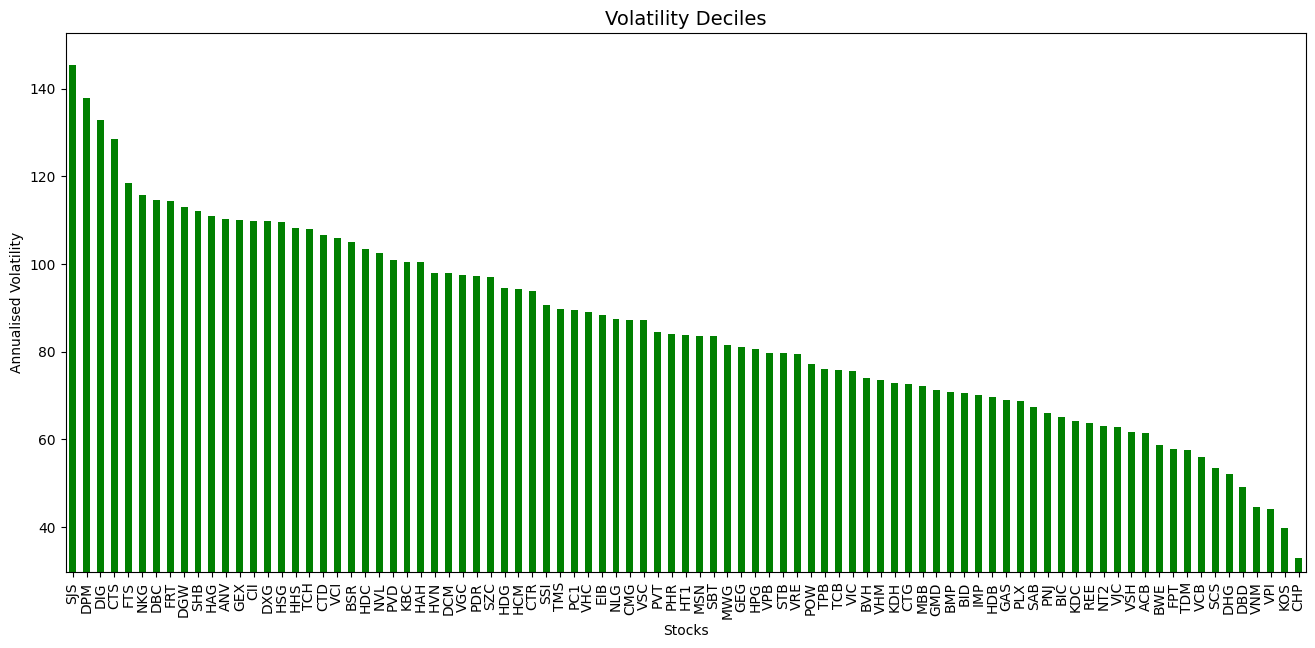

In [11]:
import matplotlib.pyplot as plt

df_std = df_pc.std()
data_std = df_pc.std()*(252**0.5)*100

vol_sorted = data_std.sort_values(ascending=False)
top_decile = vol_sorted[:int(len(data_std))]
top_decile.plot.bar(figsize=(16,7),color='green',ylim=top_decile.min()*0.9)
plt.title('Volatility Deciles', fontsize=14)
plt.xlabel('Stocks')
plt.ylabel('Annualised Volatility')
plt.show()

In [12]:
pct_window = 3
std_window = 3
rsi_window = 14
std_threshold = 2.5

In [13]:
# # Compute the 1-day percent change using the pct_change function
df_pct = df_price.pct_change()

# A function is defined to compute the RSI function of talib package
def calc_rsi(series, timeperiod):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(timeperiod, min_periods=timeperiod).mean()
    avg_loss = loss.rolling(timeperiod, min_periods=timeperiod).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def get_momentum_rank(df, pct_window = 3, std_window = 7, rsi_window = 20, df_vol = None):

    # Compute the 1-day percent change using the pct_change function
    df_pct = df.pct_change()

    # Add the past two days returns using the rolling_sum function
    df_pct_roll = df_pct.rolling(pct_window).sum()

    # Daily rank the cryptos in ascending order
    pct_ranks = df_pct_roll.rank(axis=1, ascending=True)

    # Compute the rolling standard deviation for the past 7 days
    df_std_roll = df_pct.rolling(std_window).std()

    # Daily rank the cryptos in descending order
    std_ranks = df_std_roll.rank(axis=1, ascending=False)

    # Compute the RSI
    df_rsi = df.apply(lambda r: calc_rsi(r, rsi_window), axis=0)

    # Daily rank the RSI values in ascending order
    rsi_ranks = df_rsi.rank(axis=1, ascending=True)

    if df_vol is not None:
        df_vol_ratio = df_vol.rolling(3).mean() / df_vol.rolling(20).mean()
        df_vol_rank = df_vol_ratio.rank(axis = 1, ascending = True)        
        combined_score = pct_ranks + std_ranks + rsi_ranks + df_vol_rank
    else:
        combined_score = pct_ranks + std_ranks + rsi_ranks
        
    # Rank the combined score
    combined_ranks = combined_score.rank(axis=1)

    # Print last five rows of the combined_ranks
    combined_ranks = combined_ranks.dropna()

    return combined_ranks, df_pct_roll, pct_ranks, std_ranks, df_rsi, rsi_ranks 

# combined_ranks, df_pct_3, pct_3_ranks, std_7_ranks, df_rsi_14, rsi_14_ranks = get_momentum_rank(df, df_vol = df_vol)
combined_ranks, df_pct_3, pct_3_ranks, std_7_ranks, df_rsi_14, rsi_14_ranks = get_momentum_rank(df_price, pct_window = pct_window, std_window = std_window, rsi_window = rsi_window)


In [14]:
combined_ranks

,VCB,VIC,VHM,BID,TCB,VPB,CTG,MBB,HPG,FPT,...,TDM,HT1,NT2,SZC,SCS,BIC,HDC,GEG,DBD,CHP
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-24 09:00:00,31.0,18.0,22.0,41.0,59.5,75.0,77.5,47.0,57.0,86.0,...,79.0,76.0,42.5,82.0,26.0,81.0,27.0,4.0,20.0,70.5
2020-03-02 09:00:00,35.0,28.0,17.0,39.0,54.0,76.0,79.0,40.5,43.0,73.0,...,61.5,51.0,38.0,88.0,33.0,68.5,18.5,5.0,15.0,80.0
2020-03-09 09:00:00,40.0,29.0,46.5,24.0,33.5,55.0,68.0,28.0,46.5,66.5,...,31.5,62.0,56.0,43.5,38.0,88.5,16.0,37.0,74.0,69.0
2020-03-16 09:00:00,19.0,24.0,31.0,25.0,37.0,54.0,55.5,28.5,51.5,59.0,...,30.0,40.0,62.0,46.0,60.0,88.0,19.0,57.0,78.0,69.0
2020-03-23 09:00:00,28.0,22.0,44.5,24.0,39.0,63.0,69.5,33.5,36.5,47.0,...,25.5,49.0,65.0,42.5,64.0,89.0,28.0,68.0,82.0,71.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-28 09:00:00,26.5,6.0,22.0,21.0,45.0,87.0,58.0,36.5,52.5,30.0,...,56.0,38.0,70.0,28.0,2.0,39.0,84.5,75.0,73.0,32.0
2025-08-04 09:00:00,32.0,3.0,14.0,30.5,49.0,89.0,64.5,58.0,60.5,25.0,...,51.5,63.0,72.0,27.0,2.0,66.0,82.5,38.0,44.0,18.5
2025-08-11 09:00:00,45.0,10.0,24.5,35.0,50.0,87.0,69.0,71.0,63.0,13.0,...,47.0,41.0,58.5,26.5,2.0,73.5,83.0,18.0,53.5,29.5


In [15]:
num_stocks = 8
# Generate trading signal
def signal_generator(rank, l = 20, num_stocks = 8):
    # If the rank is less than 6 than set the signal to 0 to indicate no positions

    rank[rank <= l - num_stocks] = 0
    rank[rank > l - num_stocks] = 1
    # return the rank dataframe
    return rank


# Call the signal_generator to decide on cryptocurrency to go long on
signal = combined_ranks.copy().apply(lambda r: signal_generator(r, len(stock_list), num_stocks), axis=0)

# Print the last five rows of the signal dataframe
signal.tail()

,VCB,VIC,VHM,BID,TCB,VPB,CTG,MBB,HPG,FPT,...,TDM,HT1,NT2,SZC,SCS,BIC,HDC,GEG,DBD,CHP
datetime,,,,,,,,,,,,,,,,,,,,,
2025-07-28 09:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2025-08-04 09:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2025-08-11 09:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2025-08-18 09:00:00,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-08-25 09:00:00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
signal = signal.dropna()


In [17]:
signal.sum(axis=1)[-25:]

datetime
2025-03-10 09:00:00    8.0
2025-03-17 09:00:00    8.0
2025-03-24 09:00:00    8.0
2025-03-31 09:00:00    8.0
2025-04-08 09:00:00    8.0
2025-04-14 09:00:00    9.0
2025-04-21 09:00:00    8.0
2025-04-28 09:00:00    9.0
2025-05-05 09:00:00    8.0
2025-05-12 09:00:00    8.0
2025-05-19 09:00:00    8.0
2025-05-26 09:00:00    8.0
2025-06-02 09:00:00    8.0
2025-06-09 09:00:00    8.0
2025-06-16 09:00:00    8.0
2025-06-23 09:00:00    8.0
2025-06-30 09:00:00    8.0
2025-07-07 09:00:00    8.0
2025-07-14 09:00:00    7.0
2025-07-21 09:00:00    8.0
2025-07-28 09:00:00    8.0
2025-08-04 09:00:00    8.0
2025-08-11 09:00:00    8.0
2025-08-18 09:00:00    8.0
2025-08-25 09:00:00    8.0
dtype: float64

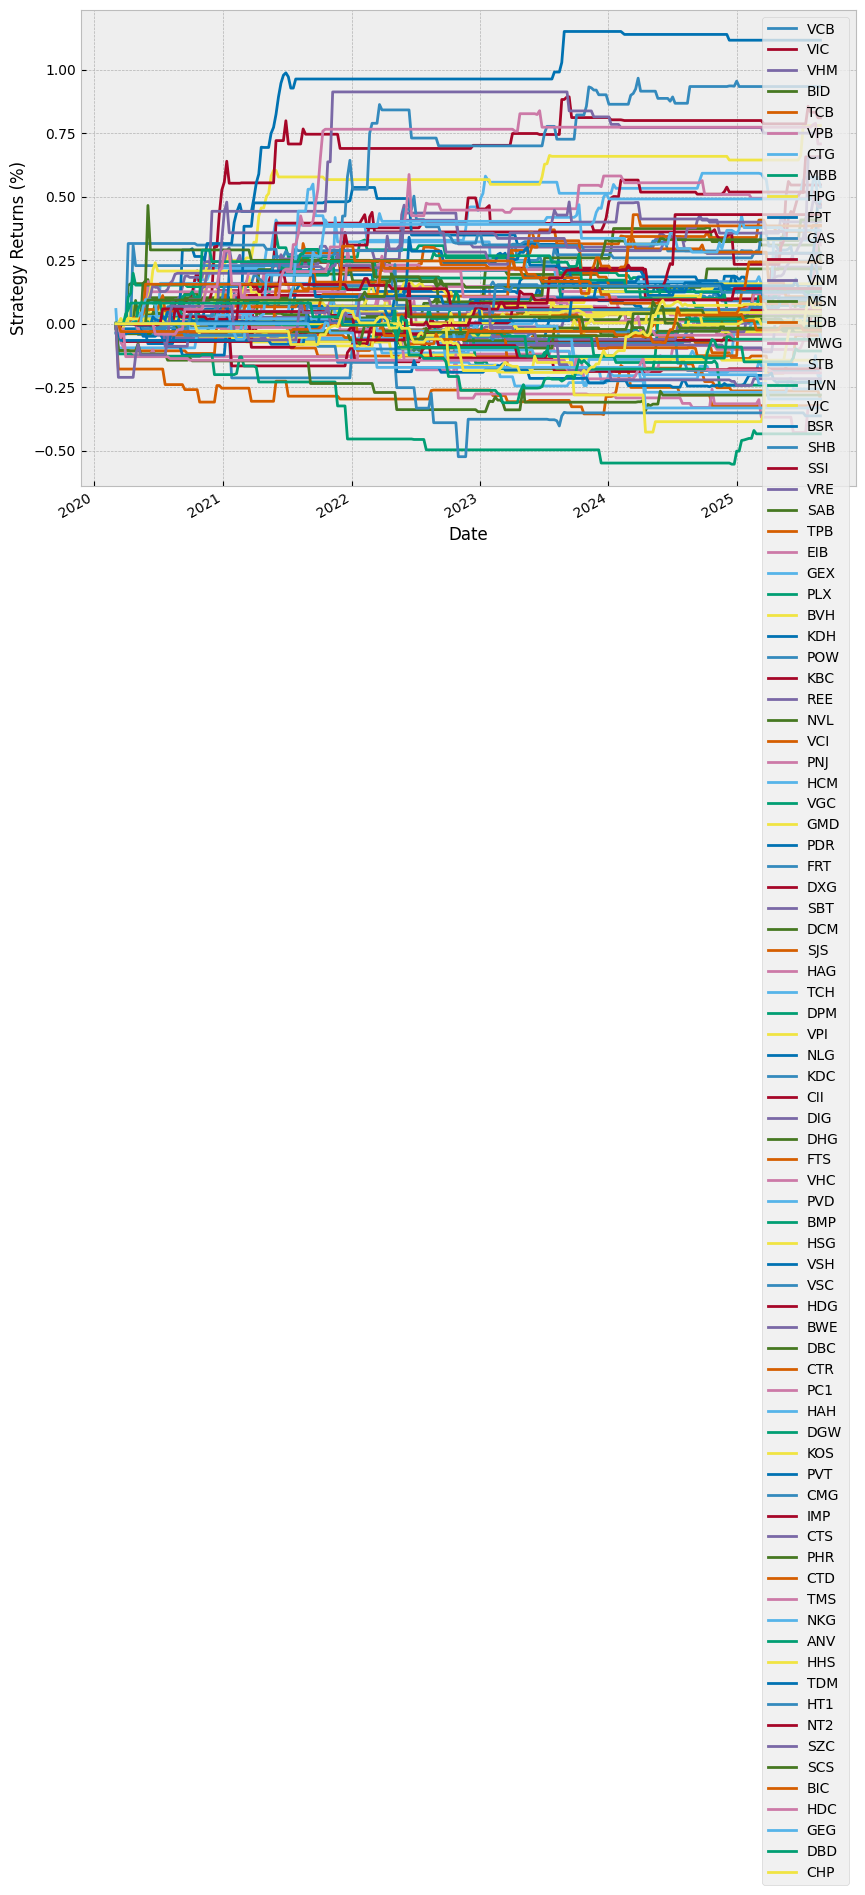

In [18]:
# Import matplotlib package to plot the graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("bmh")

# Compute the strategy returns for each of the cryptocurrencies
strategy_returns = signal.shift(1) * df_pct
# strategy_returns = signal.shift(1) * df_pct_with_cutloss

# Plot the cumulative sum of the returns for each of the cryptos
strategy_returns.cumsum().plot(figsize=(10, 7))
plt.xlabel('Date')
plt.ylabel('Strategy Returns (%)')
plt.show()

278


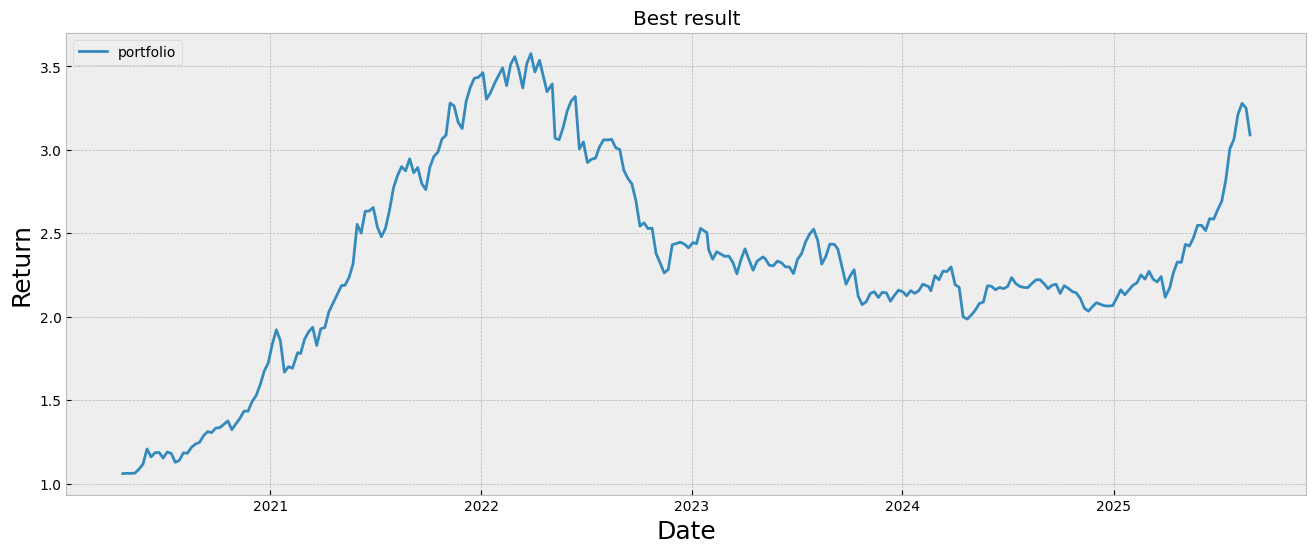

In [19]:
# Compute the strategy returns for all the cryptocurrencies in the portfolio.
# An equal weight is assumed for each of the cryptocurrency
# And therefore the strategy returns are divided by the number of positions

start_date = 21
end_date = -1

daily_ret = strategy_returns[start_date:].sum(axis=1) / signal.loc[strategy_returns[start_date:].index].abs().sum(axis=1)
daily_ret = daily_ret[1:]
# daily_ret = portfolio["signal"][start_date:].shift(1) * daily_ret[1:]

print(len(daily_ret))

x = (daily_ret + 1 - 0.001).cumprod()

# x = (daily_ret - 0.001).cumsum()
# y = (df_pct["BTCUSDT"].loc[signal.index][start_date:]).cumsum()


result = pd.DataFrame(data={"portfolio" : x, "datetime" : x.index})
result.index = pd.DatetimeIndex(result['datetime'])

plt.figure(figsize=(16,6))
plt.title("Best result")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Return', fontsize=18)
# plt.plot(train['close'])
plt.plot(result[['portfolio']])
plt.legend(['portfolio'], loc='upper left')
plt.show()


In [24]:
today = signal.iloc[-2]
for i in range(len(signal.columns)):
    if today[i] == 1:
        print(signal.columns[i])

BID
VPB
CTG
ACB
HDB
STB
BSR
POW


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [25]:
today = signal.iloc[-1]
for i in range(len(signal.columns)):
    if today[i] == 1:
        print(signal.columns[i])

VIC
VHM
BSR
SSI
VRE
SBT
TDM
NT2


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
